In [1]:

from __future__ import print_function

import sys

# sys.path.extend(['/home/jogi/git/repository/dcnn_acdc'])
sys.path.extend(['/home/jorg/repository/dcnn_acdc'])

import matplotlib
import matplotlib.pyplot as plt

from matplotlib import cm


from datetime import datetime
from pytz import timezone
import itertools
import copy

import SimpleITK as sitk
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
import glob
from collections import OrderedDict

from in_out.load_data import ACDC2017DataSet
from config.config import config
from utils.experiment import Experiment, ExperimentHandler
from utils.batch_handlers import TwoDimBatchHandler
from plotting.learning_curves import loss_plot

from models.dilated_cnn import BaseDilated2DCNN

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:

exper = ExperimentHandler.load_experiment("/home/jorg/repository/dcnn_acdc/logs/20180215_11_55_00_dcnnv1_150000E_lr2e02")

exper_hdl = ExperimentHandler(exper, use_logfile=False)
exper_hdl.set_root_dir("/home/jorg/repository/dcnn_acdc")

Load from /home/jorg/repository/dcnn_acdc/logs/20180215_11_55_00_dcnnv1_150000E_lr2e02/stats/exper_stats.dll


150000


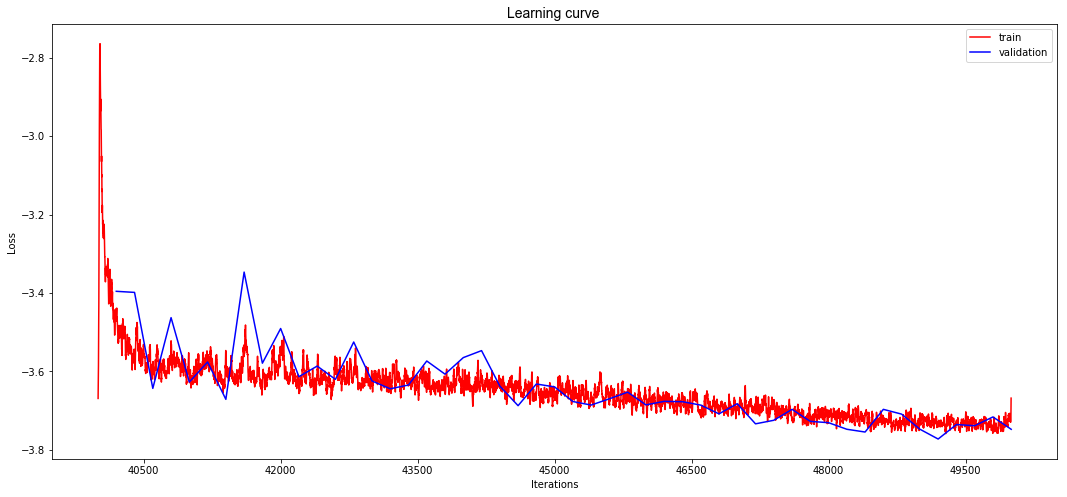

In [30]:
loss_plot(exper, width=18, validation=True, log_scale=False,
          save=False, do_average=True, epoch_range=[40001, 50000])

In [3]:

model = exper_hdl.load_checkpoint(verbose=False)

INFO - INFO - loaded existing model from checkpoint /home/jorg/repository/dcnn_acdc/logs/20180215_11_55_00_dcnnv1_150000E_lr2e02/checkpoints/BaseDilated2DCNNcheckpoint150000.pth.tar


In [4]:
print(exper_hdl.exper.config.data_dir)
dataset = ACDC2017DataSet(exper_hdl.exper.config, search_mask=exper_hdl.exper.config.dflt_image_name + ".mhd",
                          fold_ids=[0], preprocess=False, debug=False)

/home/jorg/repository/dcnn_acdc/data/Folds/
('/home/jorg/repository/dcnn_acdc', '/home/jorg/repository/dcnn_acdc/data/Folds/')
('self.data_dir ', '/home/jorg/repository/dcnn_acdc/data/Folds/')
_set_pathes False
INFO - Using folds [0] - busy loading images/references...this may take a while!
INFO - >>> Search for /home/jorg/repository/dcnn_acdc/data/Folds/fold0/train/images_iso/*patient*.mhd <<<
INFO - Using folds [0] - loaded 200 files: 2892 slices in train set, 912 slices in validation set


In [5]:
def test_run(exper_hdl, dcnn_model, dataset, batch_size=32):
    val_batch = TwoDimBatchHandler(exper_hdl.exper, batch_size=batch_size,
                                        test_run=True)
    val_batch.generate_batch_2d(dataset.images(train=False), dataset.labels(train=False))
    val_loss, val_pred = dcnn_model.do_validate(val_batch, voxel_spacing=1.4, compute_hd=True)
    val_batch.set_pred_labels(val_pred)
    val_accuracy = dcnn_model.get_accuracy()
    dice_loss_es, dice_loss_ed = dcnn_model.get_dice_losses(average=True)
    hd_stats, val_hausdorff = dcnn_model.get_hausdorff()
    # val_batch.save_batch_img_to_files()
    return val_batch, hd_stats, val_hausdorff

val_batch, hd_stats, val_hd = test_run(exper_hdl, model, dataset)
print(len(val_hd))
print("Hausdorff {}".format(np.array_str(hd_stats.flatten(), precision=3)))


6
Hausdorff [ 11.368  15.384   4.663   3.081   3.511   2.318   8.273  11.789   4.489
   3.517   8.4    28.089]


In [ ]:
val_batch.save_batch_img_to_files()

Number of subplots 40


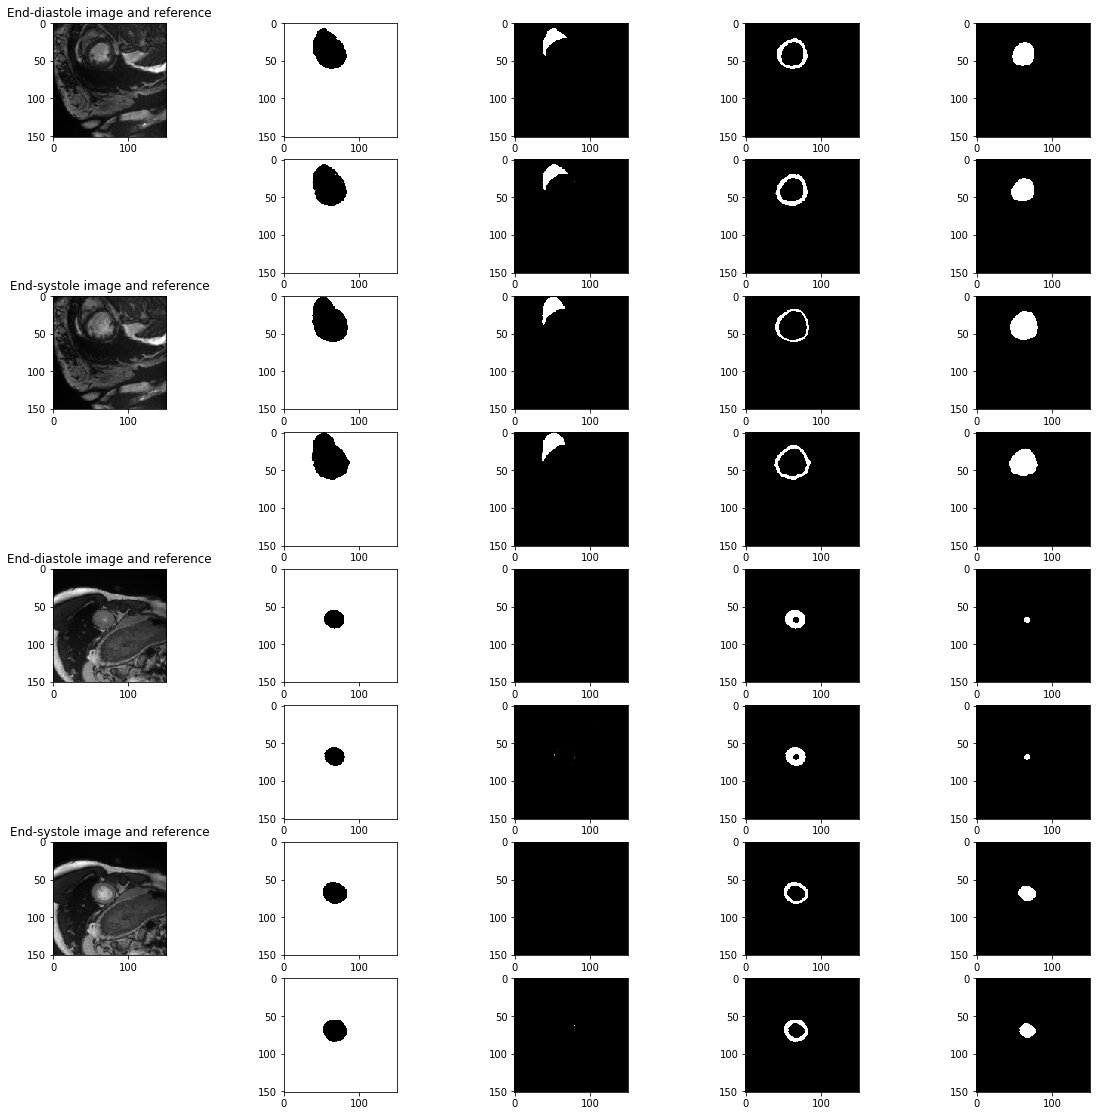

In [6]:
val_batch.visualize_batch(width=20, height=100, num_of_images=2)

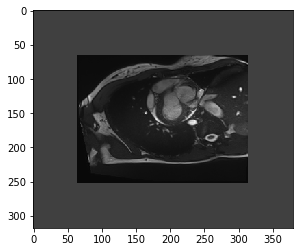

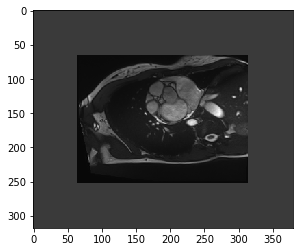

In [15]:
from in_out.read_save_images import load_mhd_to_numpy

idx = 888
image = dataset.images(train=True)[idx]
img_ed = image[0]
img_es = image[1]
plt.imshow(img_es, cmap=cm.gray)
plt.show()

plt.imshow(img_ed, cmap=cm.gray)
plt.show()

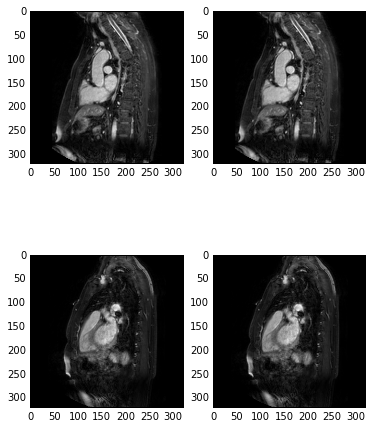

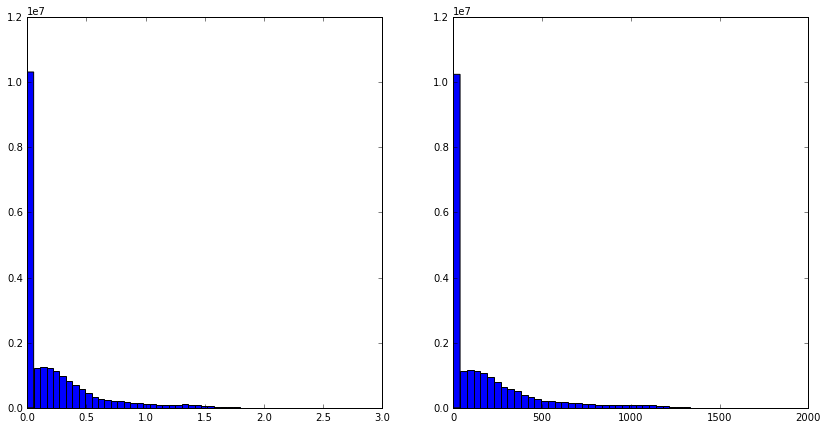

In [3]:

all_data_raw = np.empty(0)
all_data_norm = np.empty(0)

l_dataset = data_set.__len__()
series_idx = 50
fig = plt.figure(figsize=(6, 8))
counter = 0
data_set.normalize_values()

for idx in np.arange(l_dataset):
    img = data_set.images_raw[idx]
    img_norm = data_set.images[idx]
    all_data_raw = np.append(all_data_raw, np.ravel(img))
    all_data_norm = np.append(all_data_norm, np.ravel(img_norm))
    counter += 1
    ax = plt.subplot(l_dataset, 2, counter)
    plt.imshow(img[series_idx], cmap=cm.gray)
    counter += 1
    ax = plt.subplot(l_dataset, 2, counter)
    plt.imshow(img_norm[series_idx], cmap=cm.gray)

plt.show()
plt.close()

data_set.show_histogram(raw=True)